# 04. Model Comparison (SINTA 3 Report)

This notebook is structured to generate the figures and tables required for **SINTA 3** publication standards.

## Structure:
1.  **Methodology**: Data description, Descriptive Statistics, and Feature Correlation.
2.  **Architecture**: System overview (placeholder for diagram).
3.  **Results**: Comprehensive model comparison (Metrics & Actual vs Predicted plots).
4.  **Deep Dive**: Detailed analysis of the proposed XGBoost model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12


## A. Methodology (Data & Preprocessing)

We analyze the Ethereum block features used for training.


In [2]:
# Load Data
data_path = Path("../data/features.parquet")
if data_path.exists():
    df = pd.read_parquet(data_path)
    print(f"Loaded data: {df.shape}")
else:
    print("⚠️ Data not found at ../data/features.parquet")
    df = pd.DataFrame()


Loaded data: (9994, 66)


### Table 1: Descriptive Statistics
Overview of key features: `baseFee`, `gasUsed`, `transactionCount`, and the target `baseFee_next`.


In [3]:
if not df.empty:
    # Select columns
    cols_to_desc = ['baseFeePerGas', 'gasUsed', 'transactionCount', 'baseFee_next']
    cols_to_desc = [c for c in cols_to_desc if c in df.columns]
    
    # Create a display dataframe with readable units
    df_disp = df[cols_to_desc].copy()
    
    # Convert to Gwei (1e9)
    if 'baseFeePerGas' in df_disp.columns:
        df_disp['baseFeePerGas (Gwei)'] = df_disp['baseFeePerGas'] / 1e9
        df_disp.drop(columns=['baseFeePerGas'], inplace=True)
        
    if 'baseFee_next' in df_disp.columns:
        df_disp['baseFee_next (Gwei)'] = df_disp['baseFee_next'] / 1e9
        df_disp.drop(columns=['baseFee_next'], inplace=True)
        
    # Convert to Millions (1e6)
    if 'gasUsed' in df_disp.columns:
        df_disp['gasUsed (M)'] = df_disp['gasUsed'] / 1e6
        df_disp.drop(columns=['gasUsed'], inplace=True)

    desc_stats = df_disp.describe().T
    
    # Format for display
    desc_stats['mean'] = desc_stats['mean'].apply(lambda x: f"{x:,.2f}")
    desc_stats['50%'] = desc_stats['50%'].apply(lambda x: f"{x:,.2f}")
    desc_stats['std'] = desc_stats['std'].apply(lambda x: f"{x:,.2f}")
    desc_stats['min'] = desc_stats['min'].apply(lambda x: f"{x:,.2f}")
    desc_stats['max'] = desc_stats['max'].apply(lambda x: f"{x:,.2f}")
    
    print("Table 1: Descriptive Statistics (Units: Gwei for Fees, Millions for Gas)")
    display(desc_stats[['mean', '50%', 'min', 'max', 'std']])


Table 1: Descriptive Statistics (Units: Gwei for Fees, Millions for Gas)


,mean,50%,min,max,std
baseFeePerGas (Gwei),0.23,0.20,0.12,1.14,0.14
baseFee_next (Gwei),0.23,0.20,0.12,1.14,0.14
gasUsed (M),30.62,24.84,0.00,60.05,17.68


### Figure 1: Feature Correlation Heatmap
Analysis of correlation between input features and the target variable to justify feature selection.


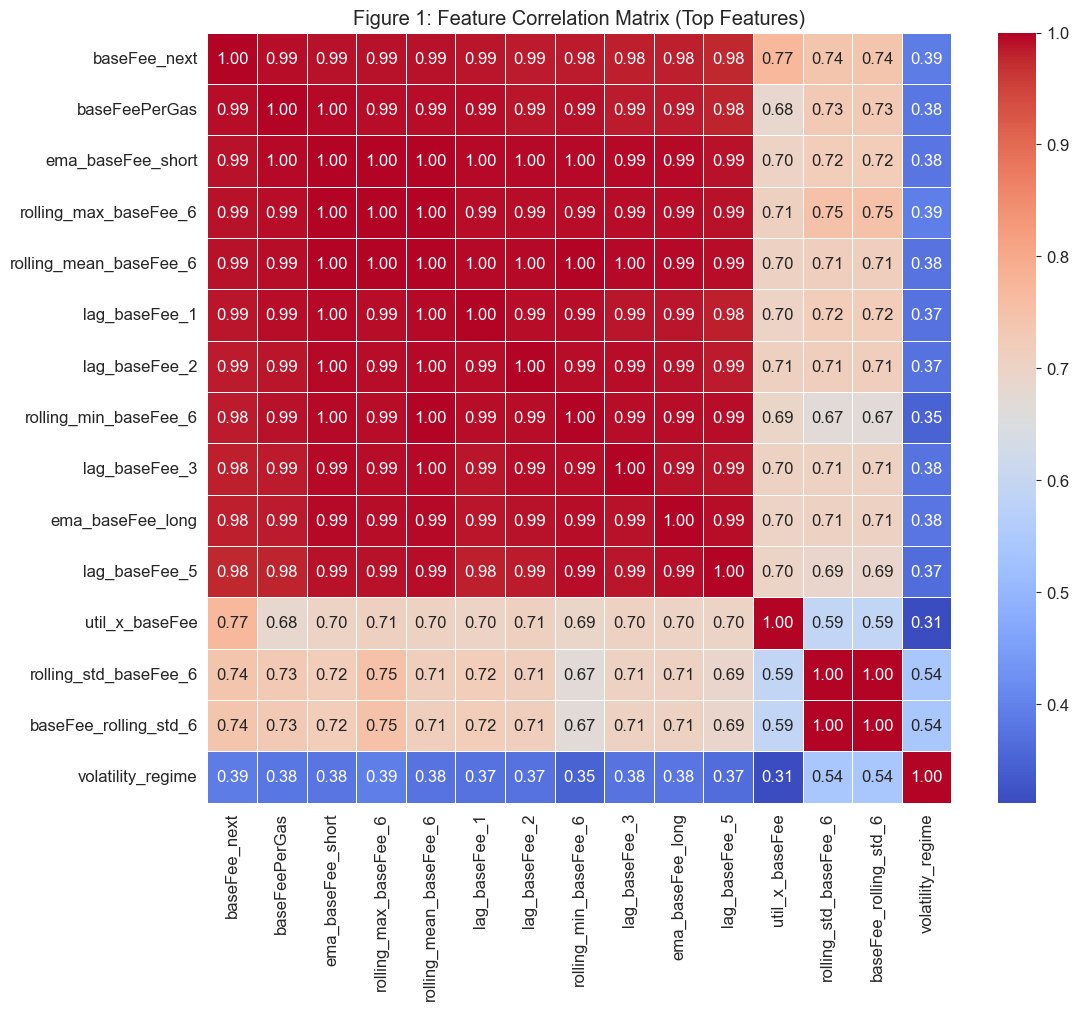

In [4]:
if not df.empty:
    plt.figure(figsize=(12, 10))
    # Select a subset of important features for readability
    target_corr = df.corr()[['baseFee_next']].sort_values(by='baseFee_next', ascending=False)
    
    # Top 10 + Bottom 5 features
    top_feats = target_corr.index[:15]
    
    sns.heatmap(df[top_feats].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Figure 1: Feature Correlation Matrix (Top Features)")
    plt.show()


## B. Experimental Design (Architecture)

### Figure 2: System Architecture
*Place your system flow diagram here (Raw RPC -> Feature Eng -> XGBoost -> Prediction).*
> **Note**: This figure should be created using Visio or Draw.io based on `project_architecture.md`.


## C. Results & Discussion

Comparison of the Proposed XGBoost model against Benchmarks (Random Forest, Gradient Boosting, LightGBM).


In [5]:
# Load Metrics
results = {}

# Benchmarks
bench_path = Path("../models/benchmarks/benchmark_summary.json")
if bench_path.exists():
    with open(bench_path, 'r') as f:
        benchs = json.load(f)
        results.update(benchs)

# XGBoost (Proposed)
xgb_path = Path("../models/xgboost_notebook/metrics.json")
if xgb_path.exists():
    with open(xgb_path, 'r') as f:
        xgb_m = json.load(f)
        results["XGBoost (Proposed)"] = xgb_m

# Create Table 2
if results:
    df_res = pd.DataFrame(results).T
    # Filter unwanted models
    drop_models = ['linear_regression', 'ridge_regression']
    df_res = df_res.drop(index=[m for m in drop_models if m in df_res.index], errors='ignore')
    
    # Select cols
    cols = ["r2", "mape", "rmse_gwei", "mae_gwei"]
    df_res = df_res[cols].rename(columns={
        "r2": "R-Squared", "mape": "MAPE (%)", 
        "rmse_gwei": "RMSE (Gwei)", "mae_gwei": "MAE (Gwei)"
    })
    df_res = df_res.sort_values("R-Squared", ascending=False)
    
    print("Table 2: Model Performance Comparison")
    display(df_res)


Table 2: Model Performance Comparison


,R-Squared,MAPE (%),RMSE (Gwei),MAE (Gwei)
XGBoost (Proposed),0.985954,3.438077,0.008010,0.006044
gbr,0.981773,4.557069,0.009122,0.007757
lightgbm,0.980619,4.740506,0.009407,0.008028
random_forest,0.977321,4.946341,0.010176,0.008405


### Actual vs Predicted: Multi-Model Comparison
Visualizing how each model tracks the ground truth (first 150 test points).


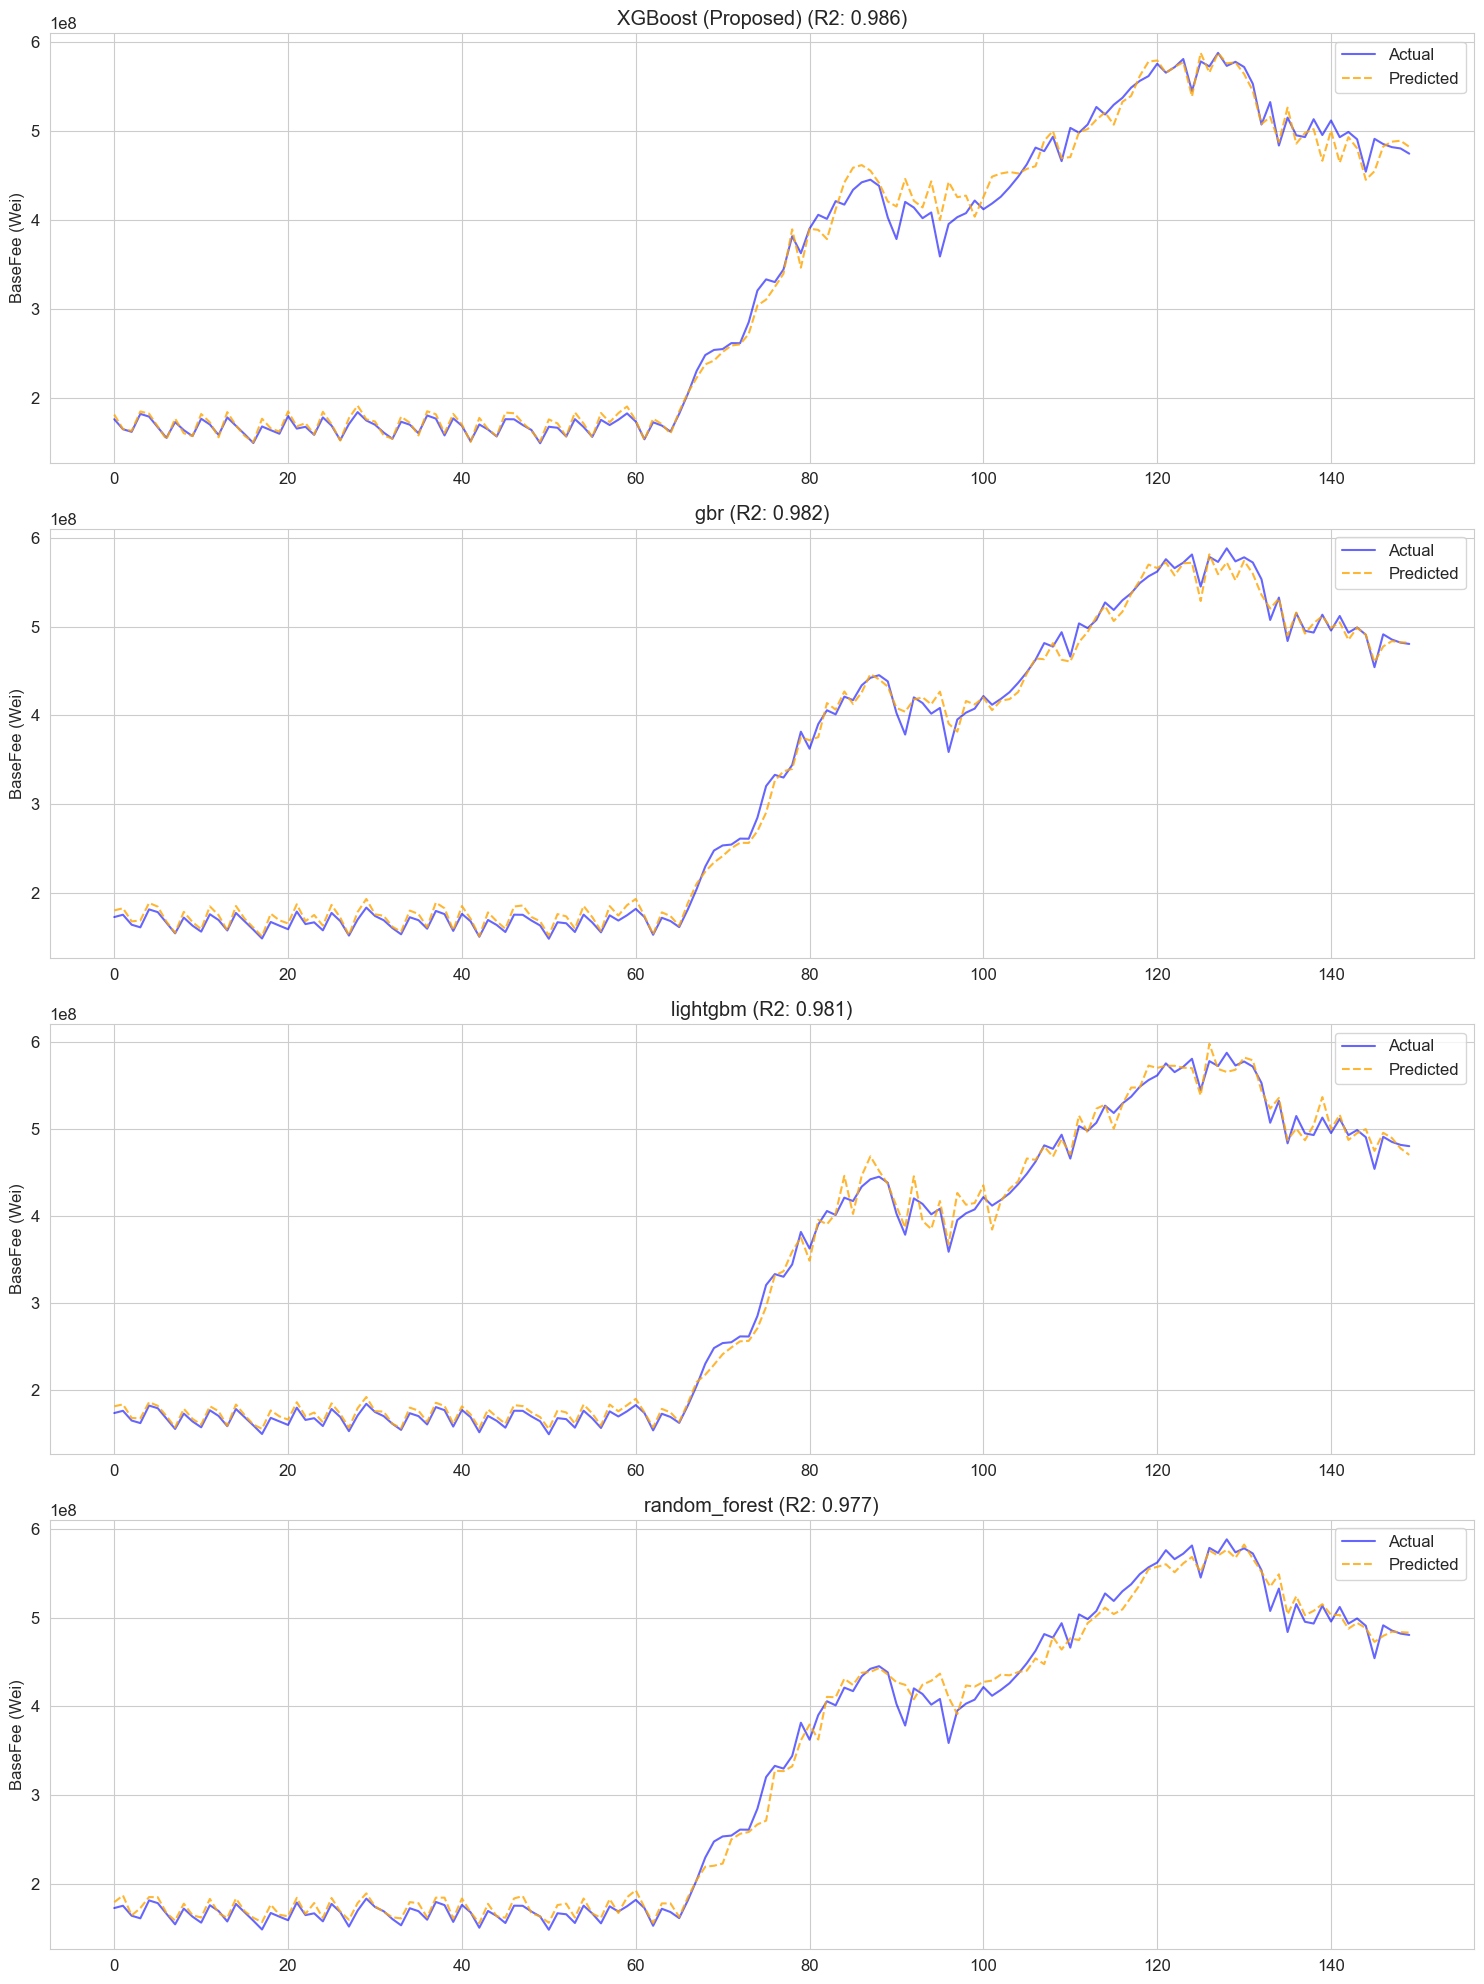

In [6]:
models_to_plot = ["XGBoost (Proposed)", "gbr", "lightgbm", "random_forest"]
# Define paths
xgb_pred_path = Path("../models/xgboost_notebook/test_predictions.parquet")
bench_dir = Path("../models/benchmarks")

fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(15, 5 * len(models_to_plot)))
if len(models_to_plot) == 1: axes = [axes]

for i, model_name in enumerate(models_to_plot):
    ax = axes[i]
    y_true, y_pred = None, None
    
    try:
        if "XGBoost" in model_name:
            if xgb_pred_path.exists():
                tmp = pd.read_parquet(xgb_pred_path)
                y_true = tmp['y_true'].values
                y_pred = tmp['y_pred'].values
        else:
            # Benchmark paths
            pred_f = bench_dir / model_name / "predictions.npy"
            true_f = bench_dir / model_name / "y_test.npy"
            if pred_f.exists() and true_f.exists():
                y_pred = np.load(pred_f)
                y_true = np.load(true_f)
        
        if y_true is not None and y_pred is not None:
            # Handle potential length mismatch (e.g. 1998 vs 1999)
            min_len = min(len(y_true), len(y_pred))
            y_true = y_true[:min_len]
            y_pred = y_pred[:min_len]

            # Limit to 150
            limit = 150
            ax.plot(y_true[:limit], label="Actual", color='blue', alpha=0.6)
            ax.plot(y_pred[:limit], label="Predicted", color='orange', linestyle='--', alpha=0.8)
            
            # Formating
            r2 = r2_score(y_true, y_pred)
            ax.set_title(f"{model_name} (R2: {r2:.3f})")
            ax.set_ylabel("BaseFee (Wei)")
            ax.legend()
        else:
            ax.text(0.5, 0.5, f"Data not found for {model_name}", ha='center')
            
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {e}", ha='center')

plt.tight_layout()
plt.show()


## D. Deep Dive: Proposed XGBoost Model
Detailed analysis of the best performing model.


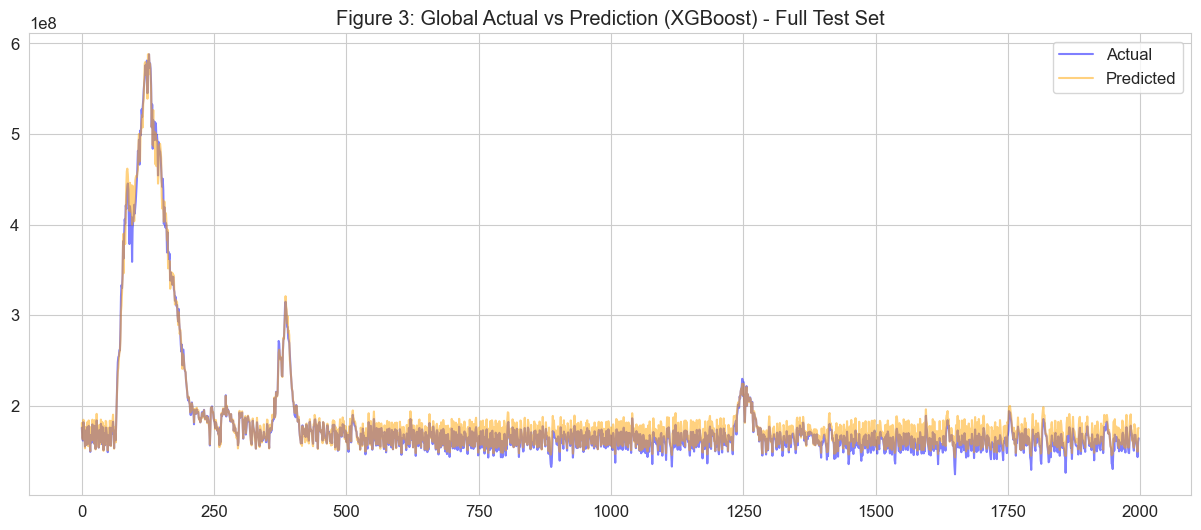

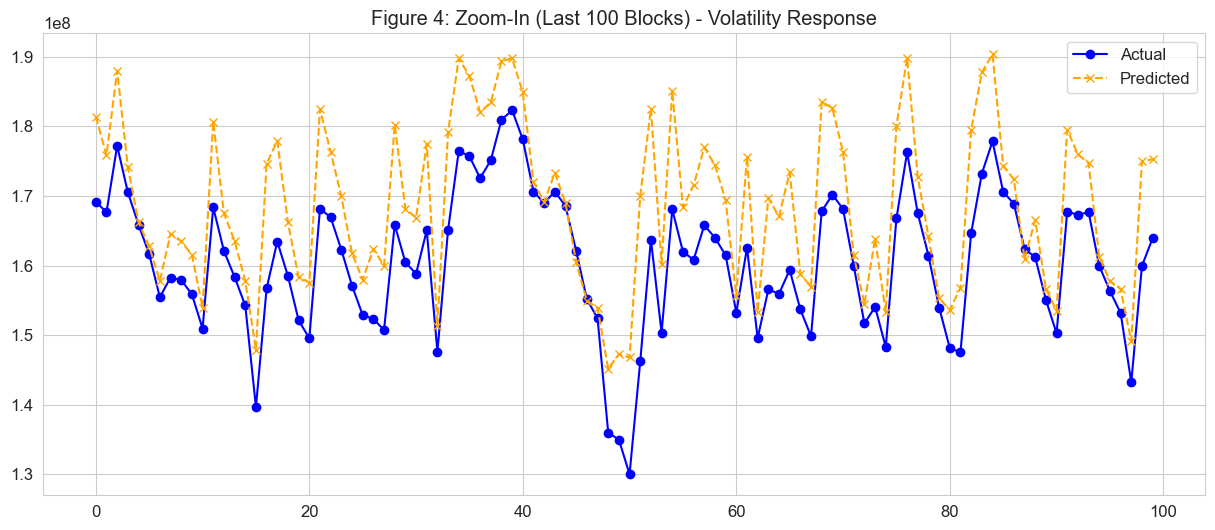

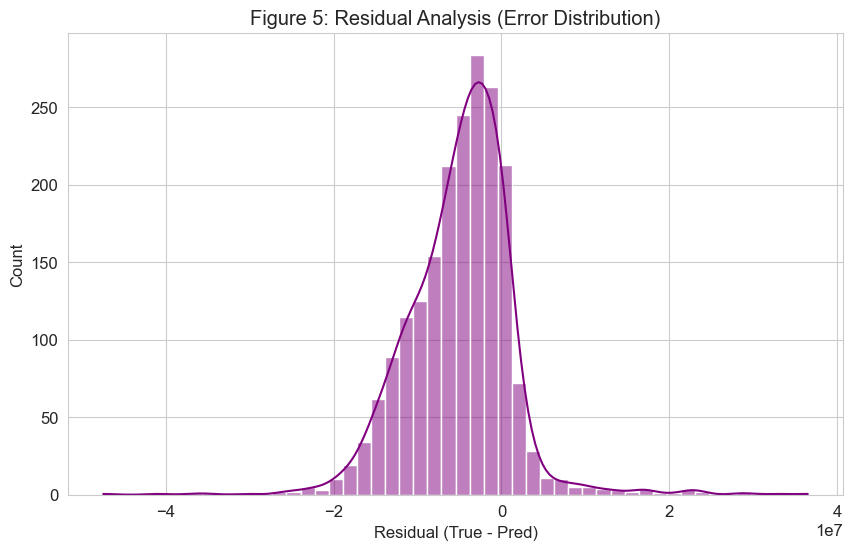

In [7]:
# Figure 3: Global
if xgb_pred_path.exists():
    df_test = pd.read_parquet(xgb_pred_path)
    plt.figure(figsize=(15, 6))
    plt.plot(df_test['y_true'].values, label="Actual", color='blue', alpha=0.5)
    plt.plot(df_test['y_pred'].values, label="Predicted", color='orange', alpha=0.5)
    plt.title("Figure 3: Global Actual vs Prediction (XGBoost) - Full Test Set")
    plt.legend()
    plt.show()
    
    # Figure 4: Zoom
    plt.figure(figsize=(15, 6))
    plt.plot(df_test['y_true'].values[-100:], label="Actual", color='blue', marker='o')
    plt.plot(df_test['y_pred'].values[-100:], label="Predicted", color='orange', marker='x', linestyle='--')
    plt.title("Figure 4: Zoom-In (Last 100 Blocks) - Volatility Response")
    plt.legend()
    plt.show()
    
    # Figure 5: Residuals
    residuals = df_test['y_true'] - df_test['y_pred']
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=50, color='purple')
    plt.title("Figure 5: Residual Analysis (Error Distribution)")
    plt.xlabel("Residual (True - Pred)")
    plt.show()
